---
<h1 align="center">
<h1 align="center"> Ejemplos de Web Structure Mining
<h2 align="center">  Profesor: Felipe Hernández M.
<h3 align="center"> IN5526 - Web Intelligence
<h3 align="center"> Primavera 2024

---

##PageRank

- Source (sólo imágenes): https://medium.com/@sarthakanand/page-rank-b7072c61dd85

- Basado en la idea de que la popularidad de un sitio Web se determina no solo por la cantidad de links entrantes, sino que también por el tipo de links entrantes.

- Un link entrante proveniente de un sitio con un ranking alto, es más valioso que un link entrante proveniente de un sitio de ranking más bajo.

####Algoritmo

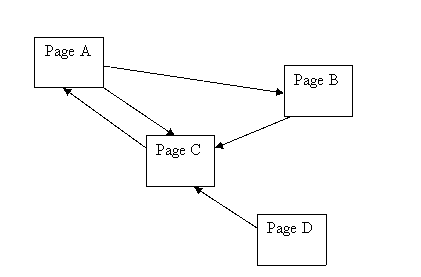

- Primero notar que si existen sitios Web sin links salientes, entonces estos no contribuyen al ranking.

- Inicialmente, el PageRank de todos los sitios es 1/n.

- El peso de cada arista del grafo es la probabilidad de salir desde un sitio Web A a un sitio Web B. Esto permite expresar el grafo en términos de probabilidades:

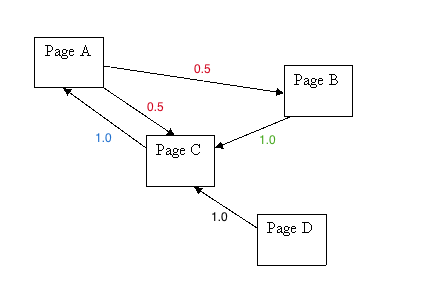

- El PageRank de cada sitio Web se determina aplicando el algoritmo de PageRank. El proceso se repite hasta que el algoritmo converge (que su valor ra no cambia más allá de un valor muy pequeño).

- El algoritmo incorpora una constante d (damping factor) que agrega algo de "aleatoriedad" al grafo. "d" Se puede interpretar como la probabilidad de que el usuario se moverá efectivamente al sitio vinculado, mientras que "1-d" es la probabilidad de escoger un sitio al azar.

Luego:

- PageRank(i + 1) = (dT + ((1-d)/n)E) * PageRank(i)
- PageRank(0) = vector de (1/n)

- T es la matriz estocástica o matriz de transición representativa del grafo
- E es una matriz de 1s

Pagerank {'1': 0.3725262460913331, '2': 0.19582365458881656, '3': 0.39415009931985023, '4': 0.037500000000000006}


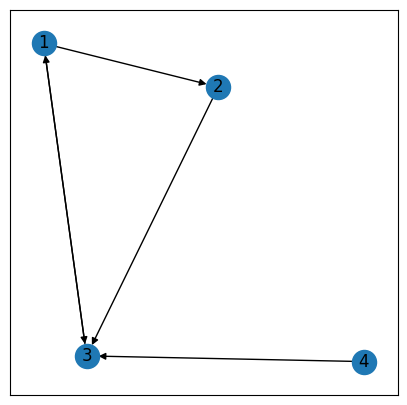

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

G.add_edges_from([('1', '2'), ('2', '3'),
                  ('1', '3'), ('4', '3'),
                  ('3', '1')])

plt.figure(figsize =(5, 5))
nx.draw_networkx(G, with_labels = True)

pr = nx.pagerank(G, alpha=0.85)
print('Pagerank', pr)

## HITS

In [3]:
h, a = nx.hits(G, max_iter = 100, normalized = True)

print('Hubs', h)
print('Authorities', a)

Hubs {'1': 0.4142135623730951, '2': 0.2928932188134525, '3': 7.039376538613738e-17, '4': 0.2928932188134525}
Authorities {'1': 1.6994558310172253e-16, '2': 0.2928932188134525, '3': 0.7071067811865474, '4': -0.0}


## Identifying Web Communities

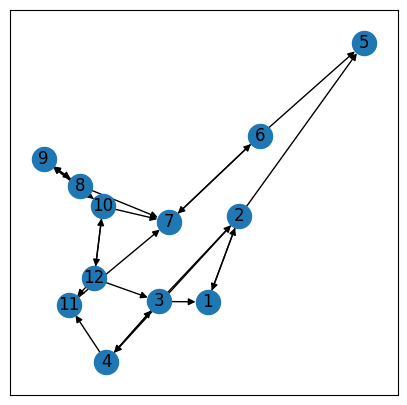

In [6]:
G = nx.DiGraph()

G.add_edges_from([('1', '2'),
                  ('2', '1'), ('2', '4'), ('2', '5'),
                  ('3', '1'), ('3', '2'), ('3', '4'),
                  ('4', '3'), ('4', '11'),
                  ('6', '5'), ('6', '7'),
                  ('7', '6'),
                  ('8', '7'), ('8', '9'),
                  ('9', '8'), ('9', '10'),
                  ('10', '7'), ('10', '9'), ('10', '12'),
                  ('11', '7'),
                  ('12', '3'), ('12', '10'), ('12', '11'),
                  ], capacity=1)

plt.figure(figsize =(5, 5))
nx.draw_networkx(G, with_labels = True)

In [8]:
def max_flow_community(G, S, k):
    G = G.copy()

    # Add a super-source 's' and connect it to all vertices in S with infinite capacity
    for v in S:
        G.add_edge('s', v, capacity=float('inf'))

    # Set capacity of all edges and ensure reverse edges exist
    for u, v in list(G.edges()):
        G[u][v]['capacity'] = k

        # Add reverse edge if not already present, with capacity k
        if not G.has_edge(v, u):
            G.add_edge(v, u, capacity=k)

    # Add super-sink 't' and connect every other node (not in S and not 's' or 't') to 't' with capacity 1
    for v in list(G.nodes()):
        if v not in S + ['s', 't']:
            G.add_edge(v, 't', capacity=1)

    # Compute the maximum flow between source 's' and sink 't'
    cut_value, (reachable, non_reachable) = nx.minimum_cut(G, 's', 't')

    # Return all vertices reachable from the source 's' (the "community")
    return reachable - {'s'}

def find_community(S, depth_limit, max_iterations, G):
    for iteration in range(max_iterations):
        # Create an empty graph to combine all the ego graphs
        G_crawl = nx.DiGraph()

        # Merge ego graphs for each seed node in S
        for seed in S:
            ego_graph = nx.ego_graph(G, seed, radius=depth_limit, undirected=False)
            G_crawl = nx.compose(G_crawl, ego_graph)

        # Debugging: print nodes in the subgraph
        print(f"Iteration {iteration}, Nodes in G_crawl:", G_crawl.nodes())

        k = len(S)
        C = max_flow_community(G_crawl, S, k)

        # Rank vertices by their degree (number of edges)
        ranked_nodes = sorted(C, key=lambda v: G_crawl.degree(v), reverse=True)

        # Add the highest ranked non-seed vertices to S
        new_members = [v for v in ranked_nodes if v not in S]
        if new_members:
            S.append(new_members[0])

        # Terminate early if no new members are added
        if len(new_members) == 0:
            break

    return S

In [9]:
depth_limit = 1  # Depth of BFS crawl
max_iterations = 3  # Max iterations for community detection

community = find_community(['1'], depth_limit, max_iterations, G)
print("Detected Community:", community)

Iteration 0, Nodes in G_crawl: ['2', '1']
Iteration 1, Nodes in G_crawl: ['2', '1', '4', '5']
Iteration 2, Nodes in G_crawl: ['2', '1', '4', '5', '3', '11']
Detected Community: ['1', '2', '4', '3']
